# **This code is meant to predict car price for the RMB Monthly Mini Challenge 3 Nowcast June**
> 1. It is meant to be executed on google colab
> 2. It generates an output file which consists of two columns, respectively the core cpi/other subcategories and their forecasted values for June

By **Bwenge840**

In [ ]:

!pip install catboost
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/CarPrice prediction/Train.csv')
test=pd.read_csv('/content/drive/MyDrive/CarPrice prediction/Test.csv')

# **1. EDA**


In [ ]:
display(train.head(),test.head()), display(train.shape,test.shape)


,ID,Make,Model,Year of manufacture,Colour,Fuel,Transmission,Condition,Mileage,Engine Size,Selling Condition,Bought Condition,price
0,ID_xXJ4kc,Honda,Accord,2012,Silver,Petrol,Automatic,Nigerian Used,149429.0,3500.0,Registered,Registered,3120000
1,ID_2k3coj,Toyota,Highlander,2008,Black,Petrol,Automatic,Nigerian Used,165972.0,3500.0,Registered,Registered,4620000
2,ID_QR1N4z,Land Rover,Range Rover Sport,2008,Black,Petrol,Automatic,Nigerian Used,114768.0,4400.0,Registered,Imported,2835000
3,ID_krFp1Y,Toyota,Camry,2006,Gray,Petrol,Automatic,Nigerian Used,211631.0,3800.0,Registered,Registered,2257500
4,ID_fBBkhN,Volvo,XC90,2006,Silver,Petrol,Automatic,Nigerian Used,145648.0,3200.0,Registered,Imported,3150000


,ID,Make,Model,Year of manufacture,Colour,Fuel,Transmission,Condition,Mileage,Engine Size,Selling Condition,Bought Condition
0,ID_CCK7xp,Chevrolet,Equinox,2011,Gray,Petrol,Automatic,Foreign Used,NaN,3000.0,Imported,Imported
1,ID_69RKZr,Honda,Pilot,2004,Silver,Petrol,Automatic,Nigerian Used,297090.0,3000.0,Registered,Registered
2,ID_6bNQFH,Honda,Pilot,2008,Silver,Petrol,Automatic,Foreign Used,366840.0,3500.0,Imported,Imported
3,ID_OxjBL4,Opel,Vectra,2005,Gray,Petrol,Automatic,Nigerian Used,212415.0,2200.0,Registered,Registered
4,ID_Bjl4Bg,Suzuki,Vitara,2006,Red,Petrol,Automatic,Nigerian Used,116776.0,2700.0,Registered,Registered


(1355, 13)

(730, 12)

(None, None)

In [ ]:
train.Make.nunique()

40

<ipython-input-6-cd6133691b9a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=train.corr()


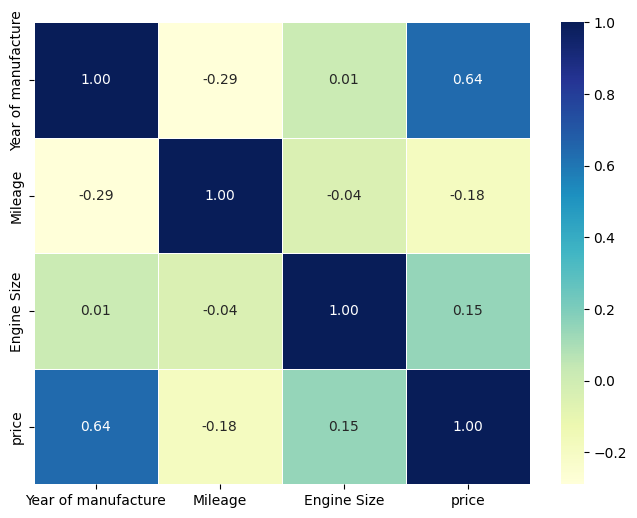

In [ ]:
corr_matrix=train.corr()
fig,ax=plt.subplots(figsize=(8,6))
ax=sns.heatmap(corr_matrix,
              annot=True,
              linewidths=0.5,
              fmt='.2f',
              cmap='YlGnBu')

# **2. DATA PREPROCESSING:**


In [ ]:
def print_missing_values(df):

   # This function take a dataframe as argument and:
        # Print The number of all missing values per columns

  for col in df.columns:
    print(f'Number of missing values in {col}: {df[col].isnull().sum()}')

def object_category(df):

    # This function take a dataframe as argument and
        # 1. Transform all object dtypes into categorical variables:
        # 2. Return the dataframe
    for col in object_columns:
      df[col]=df[col].astype('category')
    return df



def fill_nan(df):

  # This function take a dataframe as argument and does imputation:
          # 1. all categorical datatypes are added on an other category
          # 2. Numerical datatypes are filled based on the skew of the datatype
          # 3. Then return the imputed datatype

    for col in df.columns:
      if col in object_columns:
        # df[col] = df[col].cat.add_categories("nonvalue").fillna("nonvalue")
        df[col].fillna(df[col].mode()[0], inplace=True)

      else:
          # Fill NaN values based on the skewness of the data in the column
          skewness = df[col].skew()
          if skewness > 1 or skewness < -1:
            df[col].fillna(df[col].median(), inplace=True)
          else:
            df[col].fillna(df[col].mean(), inplace=True)


    return df

In [ ]:
# Sort the DataFrame by the 'date of manufacture' column in ascending order
train= train.sort_values('Year of manufacture', ascending=True)

# Creating a list of datatypes based on the column datatype
object_columns=train.select_dtypes(include=['object']).columns

#Droping the price(target)
target=train.price

#reassigning the train without price to the train dataset
train=train.drop('price',axis=1)
#Concatinating train and test to be preprocessed together
data=pd.concat([train,test],axis=0)

# Changing all object datatype to category
data=object_category(data)

In [ ]:
data.dtypes

ID                     category
Make                   category
Model                  category
Year of manufacture       int64
Colour                 category
Fuel                   category
Transmission           category
Condition              category
Mileage                 float64
Engine Size             float64
Selling Condition      category
Bought Condition       category
dtype: object

In [ ]:
data.groupby('Fuel').agg({'Engine Size':['mean','max','sum'],'Mileage':['mean','std']})

Engine Size                             Mileage               
                 mean       max        sum           mean            std
Fuel                                                                    
Diesel    3220.000000    5000.0    16100.0  148003.600000   83791.009496
Electric  4600.000000    6200.0    13800.0  234688.333333  118298.387742
Hybrid    2540.000000    3800.0    38100.0  193450.266667   78137.373938
Petrol    2988.698141  164259.0  6108899.0  204775.924864  201708.732448

In [ ]:
data['Fuel by EngineSize'] = data.groupby('Fuel')['Engine Size'].transform('sum')

In [ ]:
data['Fuel by EngineSize'].nunique()

4

In [ ]:
result = data.groupby('Fuel').agg(
    Fuel_EngineSize_mean=('Engine Size','mean'),
    Fuel_Milleage_mean=('Mileage','mean'),
    )

# Merge the aggregated result with the original DataFrame based on the 'Fuel' column
data = data.merge(result, on='Fuel', suffixes=('', '_agg'))

In [ ]:
data.columns

Index(['ID', 'Make', 'Model', 'Year of manufacture', 'Colour', 'Fuel',
       'Transmission', 'Condition', 'Mileage', 'Engine Size',
       'Selling Condition', 'Bought Condition', 'Fuel by EngineSize',
       'Fuel_EngineSize_mean', 'Fuel_Milleage_mean'],
      dtype='object')

In [ ]:
data.Fuel_Milleage_mean.unique()

array([204775.92486406, 234688.33333333, 193450.26666667, 148003.6       ])

In [ ]:
data=fill_nan(data)
data.isnull().sum()

ID                      0
Make                    0
Model                   0
Year of manufacture     0
Colour                  0
Fuel                    0
Transmission            0
Condition               0
Mileage                 0
Engine Size             0
Selling Condition       0
Bought Condition        0
Fuel by EngineSize      0
Fuel_EngineSize_mean    0
Fuel_Milleage_mean      0
dtype: int64

In [ ]:
data.dtypes

ID                      category
Make                    category
Model                   category
Year of manufacture        int64
Colour                  category
Fuel                    category
Transmission            category
Condition               category
Mileage                  float64
Engine Size              float64
Selling Condition       category
Bought Condition        category
Fuel by EngineSize       float64
Fuel_EngineSize_mean     float64
Fuel_Milleage_mean       float64
dtype: object

In [ ]:
data.Colour.value_counts()

          Black                 579
          Silver                372
          Gray                  362
          Blue                  214
          White                 166
          Red                   163
          Gold                   94
          Green                  54
          Brown                  32
          Burgandy               14
          Beige                   9
          Off white               7
          Purple                  5
          Ivory                   5
          Orange                  3
          Teal                    2
          Matt Black              2
          Pink                    1
Name: Colour, dtype: int64

### **2. a Feature derivation:**


In [ ]:
numerical_dtypes1=data.select_dtypes(include=['float','int']).columns

In [ ]:
data['Engine Size']

0       2000.0
1       1800.0
2       2200.0
3       2200.0
4       2200.0
         ...  
2079    3000.0
2080    3000.0
2081    3000.0
2082    5000.0
2083    2100.0
Name: Engine Size, Length: 2084, dtype: float64

In [ ]:
data['Car Age'] = 2023 - data['Year of manufacture']
# data['Brand'] = data['Make'].str.split().str[0]
data['Mileage per Year'] = data['Mileage'] / data['Car Age']
data['Engine Size Category'] = pd.cut(data['Engine Size'], bins=[0, 2000, 4000, float('inf')], labels=['Small', 'Medium', 'Large'])  # Adjust the bins and labels for engine size categories
data['Model age'] = pd.cut(data['Year of manufacture'], bins=[1990,2000,2010,2022, float('inf')], labels=['Old', 'Decent', 'New','very_new'])  # Adjust the bins and labels for engine size categories


# Derive Selling Condition
# data['Selling Condition'] = data['Condition'].where(data['Condition'] != data['Bought Condition'], 'Same')

# # Derive Model Age
data['Model agenumeric'] = 2023 - data.groupby('Model')['Year of manufacture'].transform('first')

# # Additional feature derivation examples:

# # Derive Car Value (assuming a valuation formula)
data['Car Value'] = data['Mileage'] * data['Engine Size'] * data['Car Age']

# # Derive Fuel Efficiency
data['Fuel Efficiency'] = data['Mileage'] / data['Engine Size']

In [ ]:
# Define the columns to group by
group_cols = ['Make','Condition']

# Define the columns to derive new features from
agg_cols = ['Engine Size', 'Mileage']

# Define the new feature suffixes
new_feature_suffixes = ['_max', '_sum', '_mean']

# Calculate the aggregated features for each group
aggregated_features = data.groupby(group_cols)[agg_cols].transform('max')
data[agg_cols[0] + new_feature_suffixes[0]] = aggregated_features[agg_cols[0]]
data[agg_cols[1] + new_feature_suffixes[0]] = aggregated_features[agg_cols[1]]
# data[agg_cols[2] + new_feature_suffixes[0]] = aggregated_features[agg_cols[2]]

aggregated_features = data.groupby(group_cols)[agg_cols].transform('sum')
data[agg_cols[0] + new_feature_suffixes[1]] = aggregated_features[agg_cols[0]]
data[agg_cols[1] + new_feature_suffixes[1]] = aggregated_features[agg_cols[1]]
# data[agg_cols[2] + new_feature_suffixes[1]] = aggregated_features[agg_cols[2]]

aggregated_features = data.groupby(group_cols)[agg_cols].transform('mean')
data[agg_cols[0] + new_feature_suffixes[2]] = aggregated_features[agg_cols[0]]
data[agg_cols[1] + new_feature_suffixes[2]] = aggregated_features[agg_cols[1]]
# data[agg_cols[2] + new_feature_suffixes[2]] = aggregated_features[agg_cols[2]]


In [ ]:
data.head()

,ID,Make,Model,Year of manufacture,Colour,Fuel,Transmission,Condition,Mileage,Engine Size,...,Model age,Model agenumeric,Car Value,Fuel Efficiency,Engine Size_max,Mileage_max,Engine Size_sum,Mileage_sum,Engine Size_mean,Mileage_mean
0,ID_of0ZCM,Mazda,Bongo,1990,White,Petrol,Manual,Nigerian Used,3322576.0,2000.0,...,NaN,33,2.192900e+11,1661.288000,3800.0,3322576.0,58600.0,7639181.0,2441.666667,318299.208333
1,ID_roRMAe,Volkswagen,Golf,1996,White,Petrol,Automatic,Nigerian Used,238748.0,1800.0,...,Old,27,1.160315e+10,132.637778,4000.0,555904.0,81000.0,5867845.0,2250.000000,162995.694444
2,ID_cxUeMJ,Toyota,Camry,1997,Red,Petrol,Automatic,Nigerian Used,251520.0,2200.0,...,Old,26,1.438694e+10,114.327273,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854
3,ID_vbPL5y,Toyota,Camry,1998,Gold,Petrol,Automatic,Nigerian Used,417775.0,2200.0,...,Old,26,2.297762e+10,189.897727,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854
4,ID_RR3iS0,Toyota,Camry,1998,Black,Petrol,Automatic,Nigerian Used,178869.5,2200.0,...,Old,26,9.837822e+09,81.304318,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854


In [ ]:
data.shape

(2084, 28)

In [ ]:
numerical_dtypes=data.select_dtypes(include=['float','int']).columns

In [ ]:
data.columns

Index(['ID', 'Make', 'Model', 'Year of manufacture', 'Colour', 'Fuel',
       'Transmission', 'Condition', 'Mileage', 'Engine Size',
       'Selling Condition', 'Bought Condition', 'Fuel by EngineSize',
       'Fuel_EngineSize_mean', 'Fuel_Milleage_mean', 'Car Age',
       'Mileage per Year', 'Engine Size Category', 'Model age',
       'Model agenumeric', 'Car Value', 'Fuel Efficiency', 'Engine Size_max',
       'Mileage_max', 'Engine Size_sum', 'Mileage_sum', 'Engine Size_mean',
       'Mileage_mean'],
      dtype='object')

In [ ]:
numerical_dtypes

Index(['Year of manufacture', 'Mileage', 'Engine Size', 'Fuel by EngineSize',
       'Fuel_EngineSize_mean', 'Fuel_Milleage_mean', 'Car Age',
       'Mileage per Year', 'Model agenumeric', 'Car Value', 'Fuel Efficiency',
       'Engine Size_max', 'Mileage_max', 'Engine Size_sum', 'Mileage_sum',
       'Engine Size_mean', 'Mileage_mean'],
      dtype='object')

In [ ]:
data.drop('ID',axis=1,inplace=True)
data.shape

(2084, 27)

In [ ]:
for col in data.columns:
  print(f'{col} datatype: {data[col].dtypes}')

Make datatype: category
Model datatype: category
Year of manufacture datatype: int64
Colour datatype: category
Fuel datatype: category
Transmission datatype: category
Condition datatype: category
Mileage datatype: float64
Engine Size datatype: float64
Selling Condition datatype: category
Bought Condition datatype: category
Fuel by EngineSize datatype: float64
Fuel_EngineSize_mean datatype: float64
Fuel_Milleage_mean datatype: float64
Car Age datatype: int64
Mileage per Year datatype: float64
Engine Size Category datatype: category
Model age datatype: category
Model agenumeric datatype: int64
Car Value datatype: float64
Fuel Efficiency datatype: float64
Engine Size_max datatype: float64
Mileage_max datatype: float64
Engine Size_sum datatype: float64
Mileage_sum datatype: float64
Engine Size_mean datatype: float64
Mileage_mean datatype: float64


In [ ]:
data.head()

,Make,Model,Year of manufacture,Colour,Fuel,Transmission,Condition,Mileage,Engine Size,Selling Condition,...,Model age,Model agenumeric,Car Value,Fuel Efficiency,Engine Size_max,Mileage_max,Engine Size_sum,Mileage_sum,Engine Size_mean,Mileage_mean
0,Mazda,Bongo,1990,White,Petrol,Manual,Nigerian Used,3322576.0,2000.0,Registered,...,NaN,33,2.192900e+11,1661.288000,3800.0,3322576.0,58600.0,7639181.0,2441.666667,318299.208333
1,Volkswagen,Golf,1996,White,Petrol,Automatic,Nigerian Used,238748.0,1800.0,Registered,...,Old,27,1.160315e+10,132.637778,4000.0,555904.0,81000.0,5867845.0,2250.000000,162995.694444
2,Toyota,Camry,1997,Red,Petrol,Automatic,Nigerian Used,251520.0,2200.0,Registered,...,Old,26,1.438694e+10,114.327273,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854
3,Toyota,Camry,1998,Gold,Petrol,Automatic,Nigerian Used,417775.0,2200.0,Registered,...,Old,26,2.297762e+10,189.897727,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854
4,Toyota,Camry,1998,Black,Petrol,Automatic,Nigerian Used,178869.5,2200.0,Registered,...,Old,26,9.837822e+09,81.304318,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854


In [ ]:
data.fillna(data.mean(), inplace=True)

<ipython-input-31-a20208f658ce>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


In [ ]:
for col in data.columns:
    print(f'Number of missing values in {col}: {data[col].isnull().sum()}')

Number of missing values in Make: 0
Number of missing values in Model: 0
Number of missing values in Year of manufacture: 0
Number of missing values in Colour: 0
Number of missing values in Fuel: 0
Number of missing values in Transmission: 0
Number of missing values in Condition: 0
Number of missing values in Mileage: 0
Number of missing values in Engine Size: 0
Number of missing values in Selling Condition: 0
Number of missing values in Bought Condition: 0
Number of missing values in Fuel by EngineSize: 0
Number of missing values in Fuel_EngineSize_mean: 0
Number of missing values in Fuel_Milleage_mean: 0
Number of missing values in Car Age: 0
Number of missing values in Mileage per Year: 0
Number of missing values in Engine Size Category: 0
Number of missing values in Model age: 1
Number of missing values in Model agenumeric: 0
Number of missing values in Car Value: 0
Number of missing values in Fuel Efficiency: 0
Number of missing values in Engine Size_max: 0
Number of missing value

In [ ]:
# from sklearn.preprocessing import RobustScaler

# # Select only numeric columns for scaling
# numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

# # Create an instance of RobustScaler
# scaler = RobustScaler()

# # Fit and transform the selected numeric columns using the scaler
# data_scaled = scaler.fit_transform(data[numeric_columns])

# # Create a new DataFrame with the scaled values and reset the column names
# data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns).reset_index(drop=True)

# # Reset the column names of the original data DataFrame
# data_reset = data.reset_index(drop=True)

# # Concatenate the scaled numeric columns with the remaining columns
# data_scaled = pd.concat([data_scaled_df, data_reset.drop(columns=numeric_columns)], axis=1)
# data = data_scaled.copy()

In [ ]:
def one_hot_encode(df, categorical_columns):
    df_encoded = pd.get_dummies(df, columns=categorical_columns)
    return df_encoded
categorical_columns=data.select_dtypes(include=['category']).columns

In [ ]:
con_data_encoded = one_hot_encode(data, categorical_columns)

In [ ]:
con_data_encoded.shape

(2084, 358)

In [ ]:
data.head()

,Make,Model,Year of manufacture,Colour,Fuel,Transmission,Condition,Mileage,Engine Size,Selling Condition,...,Model age,Model agenumeric,Car Value,Fuel Efficiency,Engine Size_max,Mileage_max,Engine Size_sum,Mileage_sum,Engine Size_mean,Mileage_mean
0,Mazda,Bongo,1990,White,Petrol,Manual,Nigerian Used,3322576.0,2000.0,Registered,...,NaN,33,2.192900e+11,1661.288000,3800.0,3322576.0,58600.0,7639181.0,2441.666667,318299.208333
1,Volkswagen,Golf,1996,White,Petrol,Automatic,Nigerian Used,238748.0,1800.0,Registered,...,Old,27,1.160315e+10,132.637778,4000.0,555904.0,81000.0,5867845.0,2250.000000,162995.694444
2,Toyota,Camry,1997,Red,Petrol,Automatic,Nigerian Used,251520.0,2200.0,Registered,...,Old,26,1.438694e+10,114.327273,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854
3,Toyota,Camry,1998,Gold,Petrol,Automatic,Nigerian Used,417775.0,2200.0,Registered,...,Old,26,2.297762e+10,189.897727,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854
4,Toyota,Camry,1998,Black,Petrol,Automatic,Nigerian Used,178869.5,2200.0,Registered,...,Old,26,9.837822e+09,81.304318,25000.0,2999999.0,1808640.0,150293199.5,2644.210526,219726.899854


(1355, 13)
(730, 12)

In [ ]:
train_df=con_data_encoded.iloc[:1355]
test_df=con_data_encoded.iloc[1355:]
train_df.shape,test_df.shape

((1355, 358), (729, 358))

In [ ]:
train_df=pd.concat([train_df,target],axis=1)
train_df.head(10)

,Year of manufacture,Mileage,Engine Size,Fuel by EngineSize,Fuel_EngineSize_mean,Fuel_Milleage_mean,Car Age,Mileage per Year,Model agenumeric,Car Value,...,Bought Condition_ Imported,Bought Condition_ Registered,Engine Size Category_Small,Engine Size Category_Medium,Engine Size Category_Large,Model age_Old,Model age_Decent,Model age_New,Model age_very_new,price
0,1990,3322576.0,2000.0,6108899.0,2988.698141,204775.924864,33,100684.121212,33,2.192900e+11,...,0,1,1,0,0,0,0,0,0,3120000
1,1996,238748.0,1800.0,6108899.0,2988.698141,204775.924864,27,8842.518519,27,1.160315e+10,...,1,0,1,0,0,1,0,0,0,4620000
2,1997,251520.0,2200.0,6108899.0,2988.698141,204775.924864,26,9673.846154,26,1.438694e+10,...,1,0,0,1,0,1,0,0,0,2835000
3,1998,417775.0,2200.0,6108899.0,2988.698141,204775.924864,25,16711.000000,26,2.297762e+10,...,0,1,0,1,0,1,0,0,0,2257500
4,1998,178869.5,2200.0,6108899.0,2988.698141,204775.924864,25,7154.780000,26,9.837822e+09,...,0,1,0,1,0,1,0,0,0,3150000
5,1998,522781.0,3000.0,6108899.0,2988.698141,204775.924864,25,20911.240000,25,3.920858e+10,...,0,1,0,1,0,1,0,0,0,4620000
6,1998,255208.0,2400.0,6108899.0,2988.698141,204775.924864,25,10208.320000,26,1.531248e+10,...,0,1,0,1,0,1,0,0,0,2184000
7,1998,100160.0,3000.0,6108899.0,2988.698141,204775.924864,25,4006.400000,25,7.512000e+09,...,0,1,0,1,0,1,0,0,0,2236000
8,1998,253594.0,2000.0,6108899.0,2988.698141,204775.924864,25,10143.760000,25,1.267970e+10,...,1,0,1,0,0,1,0,0,0,2496000
9,1998,277193.0,2000.0,6108899.0,2988.698141,204775.924864,25,11087.720000,25,1.385965e+10,...,1,0,1,0,0,1,0,0,0,2532500


In [ ]:
count=1
for col in train_df.columns:
  print(f'{count}: {col} {train_df[col].dtypes}')
  count=count+1

1: Year of manufacture int64
2: Mileage float64
3: Engine Size float64
4: Fuel by EngineSize float64
5: Fuel_EngineSize_mean float64
6: Fuel_Milleage_mean float64
7: Car Age int64
8: Mileage per Year float64
9: Model agenumeric int64
10: Car Value float64
11: Fuel Efficiency float64
12: Engine Size_max float64
13: Mileage_max float64
14: Engine Size_sum float64
15: Mileage_sum float64
16: Engine Size_mean float64
17: Mileage_mean float64
18: Make_          Acura         uint8
19: Make_          Audi         uint8
20: Make_          BMW         uint8
21: Make_          Buick         uint8
22: Make_          Cadillac         uint8
23: Make_          Chery         uint8
24: Make_          Chevrolet         uint8
25: Make_          Chrysler         uint8
26: Make_          Dodge         uint8
27: Make_          Ford         uint8
28: Make_          GAC         uint8
29: Make_          Honda         uint8
30: Make_          Hyundai         uint8
31: Make_          IVM         uint8
32: Make

In [ ]:
train=train_df.copy()
test=test_df.copy()
train

,Year of manufacture,Mileage,Engine Size,Fuel by EngineSize,Fuel_EngineSize_mean,Fuel_Milleage_mean,Car Age,Mileage per Year,Model agenumeric,Car Value,...,Bought Condition_ Imported,Bought Condition_ Registered,Engine Size Category_Small,Engine Size Category_Medium,Engine Size Category_Large,Model age_Old,Model age_Decent,Model age_New,Model age_very_new,price
0,1990,3322576.0,2000.0,6108899.0,2988.698141,204775.924864,33,100684.121212,33,2.192900e+11,...,0,1,1,0,0,0,0,0,0,3120000
1,1996,238748.0,1800.0,6108899.0,2988.698141,204775.924864,27,8842.518519,27,1.160315e+10,...,1,0,1,0,0,1,0,0,0,4620000
2,1997,251520.0,2200.0,6108899.0,2988.698141,204775.924864,26,9673.846154,26,1.438694e+10,...,1,0,0,1,0,1,0,0,0,2835000
3,1998,417775.0,2200.0,6108899.0,2988.698141,204775.924864,25,16711.000000,26,2.297762e+10,...,0,1,0,1,0,1,0,0,0,2257500
4,1998,178869.5,2200.0,6108899.0,2988.698141,204775.924864,25,7154.780000,26,9.837822e+09,...,0,1,0,1,0,1,0,0,0,3150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,2006,157126.0,5600.0,6108899.0,2988.698141,204775.924864,17,9242.705882,17,1.495840e+10,...,1,0,0,0,1,0,1,0,0,4800000
1351,2012,230584.0,3000.0,6108899.0,2988.698141,204775.924864,11,20962.181818,11,7.609272e+09,...,1,0,0,1,0,0,0,1,0,4680000
1352,2004,178869.5,2400.0,6108899.0,2988.698141,204775.924864,19,9414.184211,25,8.156449e+09,...,1,0,0,1,0,0,1,0,0,7220000
1353,2012,178869.5,2300.0,6108899.0,2988.698141,204775.924864,11,16260.863636,15,4.525398e+09,...,1,0,0,1,0,0,0,1,0,3150000


# **3. MODELLING**
> Modelling with catboost since other ensemble methods did not perform well in some tried notbooks  

In [ ]:


# Define the number of folds for cross-validation
X = train.drop('price', axis=1)
y = target
n_splits = 5

# Initialize the k-fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)

# Initialize an empty list to store the cross-validation results
rmses = []
fold_pred = []

# Define the CatBoost parameters


params = {
    'learning_rate': 0.01,
    'subsample': 0.9,
    'colsample_bylevel': 0.6,
    'max_depth': 6,
    'l2_leaf_reg': 0.001,  # Add l2_leaf_reg parameter for regularization
    'loss_function': 'RMSE',
    'random_seed': 123
}


# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}')

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]

    # Train the model on the current fold
    model = CatBoostRegressor(**params, iterations=100000, verbose=300)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=300)

    # Generate predictions on the validation set for the current fold
    preds_val = model.predict(X_val)

    # Calculate the RMSE for the current fold and store it in the list
    rmse = np.sqrt(mean_squared_error(y_val, preds_val))
    print(f'Fold {fold+1} RMSE: {rmse:.4f}\n')
    rmses.append(rmse)

    # Generate predictions on the test set for the current fold
    p2 = model.predict(test[X.columns])
    fold_pred.append(p2)

# Calculate the mean RMSE across all folds
mean_rmse = np.mean(rmses)
print(f'Mean RMSE: {mean_rmse:.4f}\n')


Fold 1
0:	learn: 4529182.9049431	test: 4275422.6884227	best: 4275422.6884227 (0)	total: 49.4ms	remaining: 1h 22m 17s
300:	learn: 2971862.0036489	test: 3600518.5847826	best: 3600355.6400911 (297)	total: 1.06s	remaining: 5m 51s
600:	learn: 2545541.6055155	test: 3612126.7932340	best: 3593129.0486264 (397)	total: 2.85s	remaining: 7m 50s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 3593129.049
bestIteration = 397

Shrink model to first 398 iterations.
Fold 1 RMSE: 3593129.0486

Fold 2
0:	learn: 4571387.5538341	test: 4087643.1607308	best: 4087643.1607308 (0)	total: 7.14ms	remaining: 11m 54s
300:	learn: 3037459.9060276	test: 3371639.1746406	best: 3337665.9919640 (209)	total: 1.74s	remaining: 9m 35s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 3337665.992
bestIteration = 209

Shrink model to first 210 iterations.
Fold 2 RMSE: 3337665.9920

Fold 3
0:	learn: 4390435.7245902	test: 4822027.3032079	best: 4822027.3032079 (0)	total: 2.92ms	remaining: 4m 51s

# **3. Most important feature selection**
>I'am gonna model on the most important 200 features in order toimprouve the model strongness

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns
top_50_features = feature_importance_df.sort_values(by='importance', ascending=False).head(200)['feature'].tolist()

In [ ]:
new_data=X[top_50_features ]

In [ ]:
new_data.shape

(1355, 200)

In [ ]:
# Define the number of folds for cross-validation
X =new_data.copy()
n_splits = 5

# Initialize the k-fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)

# Initialize an empty list to store the cross-validation results
rmses = []
fold_pred = []

# Define the CatBoost parameters


params = {
    'learning_rate': 0.15,
    'subsample': 0.9,
    'colsample_bylevel': 0.6,
    'max_depth': 4,
    'l2_leaf_reg': 0.01,  # Add l2_leaf_reg parameter for regularization
    'loss_function': 'RMSE',
    'random_seed': 123
}


# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}')

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]

    # Train the model on the current fold
    model = CatBoostRegressor(**params, iterations=100000, verbose=300)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=200)

    # Generate predictions on the validation set for the current fold
    preds_val = model.predict(X_val)

    # Calculate the RMSE for the current fold and store it in the list
    rmse = np.sqrt(mean_squared_error(y_val, preds_val))
    print(f'Fold {fold+1} RMSE: {rmse:.4f}\n')
    rmses.append(rmse)

    # Generate predictions on the test set for the current fold
    p2 = model.predict(test[X.columns])
    fold_pred.append(p2)

# Calculate the mean RMSE across all folds
mean_rmse = np.mean(rmses)
print(f'Mean RMSE: {mean_rmse:.4f}\n')


Fold 1
0:	learn: 4338752.7354575	test: 4142316.5082634	best: 4142316.5082634 (0)	total: 8.7ms	remaining: 14m 30s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 3587521.766
bestIteration = 33

Shrink model to first 34 iterations.
Fold 1 RMSE: 3587521.7660

Fold 2
0:	learn: 4374622.4597219	test: 3861200.8546544	best: 3861200.8546544 (0)	total: 4.06ms	remaining: 6m 45s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 3413155.965
bestIteration = 14

Shrink model to first 15 iterations.
Fold 2 RMSE: 3413155.9655

Fold 3
0:	learn: 4206952.0042462	test: 4614067.1207176	best: 4614067.1207176 (0)	total: 1.2ms	remaining: 2m
Stopped by overfitting detector  (200 iterations wait)

bestTest = 3911273.424
bestIteration = 37

Shrink model to first 38 iterations.
Fold 3 RMSE: 3911273.4242

Fold 4
0:	learn: 4263285.3010324	test: 4468202.9735198	best: 4468202.9735198 (0)	total: 1.77ms	remaining: 2m 57s
Stopped by overfitting detector  (200 iterations wait)

bestTest

In [ ]:
preds = np.mean(fold_pred,axis=0)
testdata=pd.read_csv('/content/drive/MyDrive/CarPrice prediction/Test.csv',low_memory=False)
submission = pd.DataFrame({"Id": testdata["ID"], "price": preds})
submission["price"] = submission["price"].apply(lambda x: f"{x:.2f}")
submission.to_csv('OutputCar.csv',index=False)

ValueError: ignored

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns
top_50_features = feature_importance_df.sort_values(by='importance', ascending=False).head(200)['feature'].tolist()

feature_importance_df['feature']
plt.figure(figsize=(20, 15));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30))
plt.title('Lightgbm features importance (top 10):')